# Cross-Validation Training

In [1]:
# Import necessary packages. 
import pandas as pd
import numpy as np 
import math
import time
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import copy

### Todo: 

* Examine the distribution of the predicted track and validation track. 
* Setting up the threshold for calculating the MSE specifically for peaks. 
* Creating Models for each histone marks.

## Data Preparation

In [18]:
# Reading data.
ml_df = pd.read_csv("sources/ML_model/output/ml_data.csv", header=0)

# Create the shuffled dataframe for randomly selecting the folds. 
ml_df_shuf = ml_df.sample(frac=1)

# Define number of folds. 
k = 4

# Create index for the folds. 
folds_index = list(range(0, ml_df_shuf.shape[0], math.ceil(ml_df_shuf.shape[0]/k))) + [ml_df_shuf.shape[0]]
folds_index = [[folds_index[i]+1, folds_index[i+1]] for i in range(len(folds_index)-1)]
folds_index[0][0] = 0
folds_index

[[0, 303615], [303616, 607230], [607231, 910845], [910846, 1214460]]

In [61]:
ml_df

avo       cur cell mark  ideas    valid
0        0.246995  0.180174  C46  M03      0  0.22644
1        0.248117  0.180174  C46  M03     92  0.22644
2        0.248174  0.180174  C46  M03      0  0.22644
3        0.247927  0.180174  C46  M03      0  0.22644
4        0.248312  0.180174  C46  M03      0  0.22644
...           ...       ...  ...  ...    ...      ...
1214455  0.063010  0.000000  C23  M25      0  0.00000
1214456  0.060978  0.000000  C23  M25      0  0.00000
1214457  0.061748  0.000000  C23  M25      0  0.00000
1214458  0.061063  0.000000  C23  M25      0  0.00000
1214459  0.061999  0.000000  C23  M25      0  0.00000

[1214460 rows x 6 columns]

In [19]:
# Creating label and feature dataset. 
label = ml_df_shuf["valid"].to_numpy()
ml_df_shuf.drop(columns=["valid"])
features_dummies = pd.get_dummies(ml_df_shuf)
features = features_dummies.to_numpy() 
print(label[0:5])
print(features[0:5,:])

[0.4194066  0.47912769 0.51961    0.499787   0.176605  ]
[[0.468564   0.48123019 0.         0.4194066  0.         0.
  0.         0.         0.         0.         0.         1.
  0.         0.         0.         1.         0.        ]
 [0.51875847 0.31617134 0.         0.47912769 0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         1.         0.         0.        ]
 [0.5656851  0.16588938 0.         0.51961    1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.        ]
 [0.14765898 0.12652433 0.         0.499787   0.         0.
  0.         0.         0.         1.         0.         0.
  0.         0.         1.         0.         0.        ]
 [0.18135708 0.17125739 0.         0.176605   0.         0.
  0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.         1.        ]]


## Cross-Validation Training

In [4]:
def time_stamp(): 
    print("[{}]".format(time.time()))

In [5]:
def cv_train(model_name, label, feature, folds): 
    predicted_set = {}
    iter_index = 0

    for validation_set in folds: 
        print("---- Creating Validation Set for data in range {}".format(validation_set))
        if model_name == "RF": 
            regr = RandomForestRegressor()
        else: 
            # Part for adding more models later. 
            print("#### Invalid Model Name. Terminating Training")
            break

        # Creating train and valid features, labels. 
        curr_test_feature = feature[validation_set[0]:validation_set[1],:]
        curr_test_label = label[validation_set[0]:validation_set[1]]
        curr_train_feature = np.delete(feature, np.s_[validation_set[0]:validation_set[1]+1], axis=0)
        curr_train_label = np.delete(label, np.s_[validation_set[0]:validation_set[1]+1], axis=0)

        start_time = time.time()
        print("-------- Start Training on {}".format(start_time))
        regr.fit(curr_train_feature, curr_train_label)
        print("-------- Finished Training, elapsed time: {}".format(time.time() - start_time))
        predicted_set[iter_index] = {
            "model": regr, 
            "predicted": regr.predict(curr_test_feature),
            "test_label": curr_test_label,
            "avocado": curr_test_feature[:,0],
            "curr_impute": curr_test_feature[:,1]
        }
        iter_index += 1

    return predicted_set

In [6]:
def pretty(d, indent=0):
   for key, value in d.items():
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))

In [7]:
model_dic = cv_train("RF", label, features, folds_index)

---- Creating Validation Set for data in range [0, 303615]
-------- Start Training on 1574182987.977485
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 58.52015209197998
---- Creating Validation Set for data in range [303616, 607230]
-------- Start Training on 1574183048.340859
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 58.19038510322571
---- Creating Validation Set for data in range [607231, 910845]
-------- Start Training on 1574183108.437985
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/

In [8]:
# Calculating the MSE for each fold. 
MSE_dict = {}
for i in range(4): 
    MSE_dict[i] = {
        "predicted": round(np.mean(abs(model_dic[i]["predicted"]-model_dic[i]["test_label"])), 4), 
        "avocado": round(np.mean(abs(model_dic[i]["avocado"]-model_dic[i]["test_label"])), 4),
        "curr_impute": round(np.mean(abs(model_dic[i]["curr_impute"]-model_dic[i]["test_label"])), 4)
    }
pretty(MSE_dict)

0
	predicted
		0.1372
	avocado
		0.1537
	curr_impute
		0.2792
1
	predicted
		0.1402
	avocado
		0.1577
	curr_impute
		0.2832
2
	predicted
		0.1361
	avocado
		0.1529
	curr_impute
		0.277
3
	predicted
		0.1367
	avocado
		0.1546
	curr_impute
		0.2823


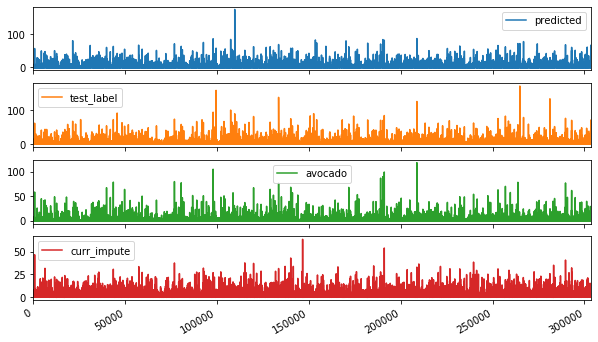

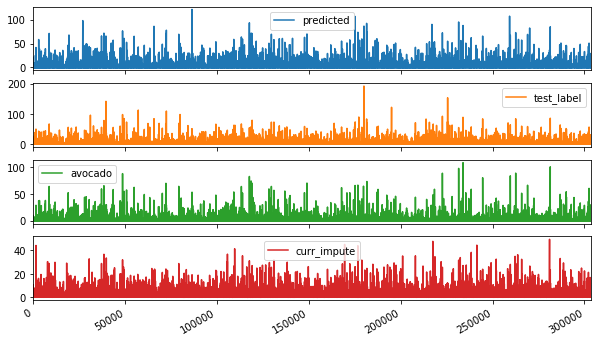

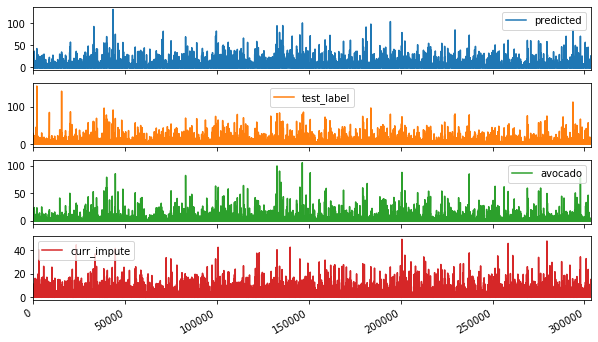

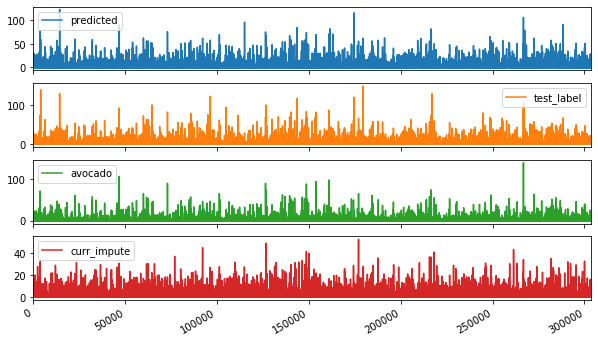

In [9]:
# Pairwise Data Visualization. 
for i in range(4): 
    temp_dic = copy.deepcopy(model_dic[i])
    temp_dic.pop("model")
    temp_plot_df = pd.DataFrame(temp_dic)
    temp_plot_df.plot(subplots=True, figsize=(10, 6))

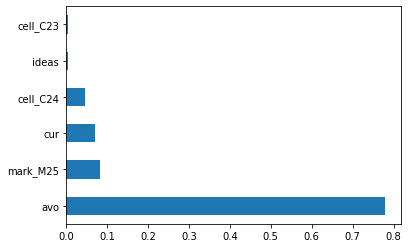

In [10]:
# Plot the feature importance. 
feat_imp_li = model_dic[0]["model"].feature_importances_
feat_importance = pd.Series(feat_imp_li, index=features_orig.columns)
feat_importance.nlargest(6).plot(kind='barh')
# print(model_dic[0]["model"].feature_importances_)

## Cross-Validated Training on Datasets Without IDEAS State

In [11]:
print(features[0,:])

[0.2037363  0.25777569 4.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.        ]


In [20]:
ml_df_shuf.head(5)

avo       cur cell mark  ideas     valid
792090   0.468564  0.481230  C32  M21      0  0.419407
1151646  0.518758  0.316171  C31  M03      0  0.479128
384424   0.565685  0.165889  C17  M03      0  0.519610
579290   0.147659  0.126524  C27  M03      0  0.499787
956422   0.181357  0.171257  C46  M25      0  0.176605

In [22]:
# Remove all IDEAS State dummies variable. 
features_wt_idea = ml_df_shuf[["avo", "cur", "cell", "mark"]]
features_wt_idea = pd.get_dummies(features_wt_idea).to_numpy()
features_wt_idea[0,:]

array([0.468564  , 0.48123019, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ])

In [23]:
model_dic_id_rmd = cv_train("RF", label, features_wt_idea, folds_index)

---- Creating Validation Set for data in range [0, 303615]
-------- Start Training on 1574183999.332468
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 56.25135779380798
---- Creating Validation Set for data in range [303616, 607230]
-------- Start Training on 1574184057.5759418
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 55.562814235687256
---- Creating Validation Set for data in range [607231, 910845]
-------- Start Training on 1574184115.145239
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklear

In [24]:
# Calculating the MSE for each fold. 
MSE_dict = {}
for i in range(4): 
    MSE_dict[i] = {
        "predicted": round(np.mean(abs(model_dic_id_rmd[i]["predicted"]-model_dic_id_rmd[i]["test_label"])), 4), 
        "avocado": round(np.mean(abs(model_dic_id_rmd[i]["avocado"]-model_dic_id_rmd[i]["test_label"])), 4),
        "curr_impute": round(np.mean(abs(model_dic_id_rmd[i]["curr_impute"]-model_dic_id_rmd[i]["test_label"])), 4)
    }
pretty(MSE_dict)

0
	predicted
		0.1371
	avocado
		0.155
	curr_impute
		0.2808
1
	predicted
		0.1385
	avocado
		0.1552
	curr_impute
		0.2796
2
	predicted
		0.1389
	avocado
		0.1541
	curr_impute
		0.2796
3
	predicted
		0.1381
	avocado
		0.1545
	curr_impute
		0.2817


## Creating Models for Each Histone Marks

### Data Preparation

In [25]:
ml_df_shuf.head(5)

avo       cur cell mark  ideas     valid
792090   0.468564  0.481230  C32  M21      0  0.419407
1151646  0.518758  0.316171  C31  M03      0  0.479128
384424   0.565685  0.165889  C17  M03      0  0.519610
579290   0.147659  0.126524  C27  M03      0  0.499787
956422   0.181357  0.171257  C46  M25      0  0.176605

In [27]:
# Print unique marks. 
marks_list = ml_df_shuf.mark.unique()
print(marks_list)

['M21' 'M03' 'M25']


In [40]:
def hist_models(mark_id, orig_df, ideas=True):
    df = orig_df[orig_df.mark == mark_id]
    label = df["valid"].to_numpy()
    if ideas: 
        features = pd.get_dummies(df[["avo", "cur", "cell", "ideas"]]).to_numpy()
    else: 
        features = pd.get_dummies(df[["avo", "cur", "cell"]]).to_numpy()

    # Define number of folds. 
    k = 4

    # Create index for the folds. 
    folds_index = list(range(0, df.shape[0], math.ceil(df.shape[0]/k))) + [df.shape[0]]
    folds_index = [[folds_index[i]+1, folds_index[i+1]] for i in range(len(folds_index)-1)]
    folds_index[0][0] = 0
    folds_index

    model_dic = cv_train("RF", label, features, folds_index)

    MSE_dict = {}
    for i in range(4): 
        MSE_dict[i] = {
            "predicted": round(np.mean(abs(model_dic[i]["predicted"]-model_dic[i]["test_label"])), 4), 
            "avocado": round(np.mean(abs(model_dic[i]["avocado"]-model_dic[i]["test_label"])), 4),
            "curr_impute": round(np.mean(abs(model_dic[i]["curr_impute"]-model_dic[i]["test_label"])), 4)
        }
    pretty(MSE_dict)

    return {
        "model_dic": model_dic, 
        "MSE": MSE_dict
    }

### Model for M21 - H3K4me2

In [37]:
m21_result = hist_models("M21", ml_df_shuf)

---- Creating Validation Set for data in range [0, 116775]
-------- Start Training on 1574188344.497136
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 17.838374853134155
---- Creating Validation Set for data in range [116776, 233550]
-------- Start Training on 1574188362.94751
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 17.883373975753784
---- Creating Validation Set for data in range [233551, 350325]
-------- Start Training on 1574188381.4168372
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklear

In [42]:
m21_result_wt_ideas = hist_models("M21", ml_df_shuf, False)

---- Creating Validation Set for data in range [0, 116775]
-------- Start Training on 1574188997.884465
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 16.571380853652954
---- Creating Validation Set for data in range [116776, 233550]
-------- Start Training on 1574189015.0444632
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 16.519545793533325
---- Creating Validation Set for data in range [233551, 350325]
-------- Start Training on 1574189032.130722
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklea

### Model for M03 - H2AFZ

In [38]:
m03_result = hist_models("M03", ml_df_shuf)

---- Creating Validation Set for data in range [0, 93420]
-------- Start Training on 1574188493.600275
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 13.731431722640991
---- Creating Validation Set for data in range [93421, 186840]
-------- Start Training on 1574188507.847035
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 12.977031230926514
---- Creating Validation Set for data in range [186841, 280260]
-------- Start Training on 1574188521.262924
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/

In [41]:
m03_result_wt_ideas = hist_models("M03", ml_df_shuf, False)

---- Creating Validation Set for data in range [0, 93420]
-------- Start Training on 1574188889.4063501
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 12.069170951843262
---- Creating Validation Set for data in range [93421, 186840]
-------- Start Training on 1574188901.90952
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 11.77048110961914
---- Creating Validation Set for data in range [186841, 280260]
-------- Start Training on 1574188914.099287
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/e

### Model for M25 - H3K79me2

In [39]:
m25_result = hist_models("M25", ml_df_shuf)

---- Creating Validation Set for data in range [0, 93420]
-------- Start Training on 1574188633.599432
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 13.147719860076904
---- Creating Validation Set for data in range [93421, 186840]
-------- Start Training on 1574188647.193089
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 12.824733972549438
---- Creating Validation Set for data in range [186841, 280260]
-------- Start Training on 1574188660.440157
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/

In [43]:
m25_result_wt_ideas = hist_models("M25", ml_df_shuf, False)

---- Creating Validation Set for data in range [0, 93420]
-------- Start Training on 1574189102.0591948
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 11.923866271972656
---- Creating Validation Set for data in range [93421, 186840]
-------- Start Training on 1574189114.4053
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
-------- Finished Training, elapsed time: 11.734225988388062
---- Creating Validation Set for data in range [186841, 280260]
-------- Start Training on 1574189126.537584
/Users/Michavillson/anaconda3/lib/python3.7/site-packages/sklearn/e

## Convert the Above Statistics into Tidy Data Format

In [44]:
print(marks_list)

['M21' 'M03' 'M25']


In [57]:
hist_list = [["Mark_id", "Iteration", "predicted", "avocado", "curr_impute", "ideas"]]
M25_list =  [["M25", i[0], i[1]["predicted"], i[1]["avocado"], i[1]["curr_impute"], False] for i in m25_result_wt_ideas["MSE"].items()]
M25_list += [["M25", i[0], i[1]["predicted"], i[1]["avocado"], i[1]["curr_impute"], True] for i in m25_result["MSE"].items()]
M03_list =  [["M03", i[0], i[1]["predicted"], i[1]["avocado"], i[1]["curr_impute"], False] for i in m03_result_wt_ideas["MSE"].items()]
M03_list += [["M03", i[0], i[1]["predicted"], i[1]["avocado"], i[1]["curr_impute"], True] for i in m03_result["MSE"].items()]
M21_list =  [["M21", i[0], i[1]["predicted"], i[1]["avocado"], i[1]["curr_impute"], False] for i in m21_result_wt_ideas["MSE"].items()]
M21_list += [["M21", i[0], i[1]["predicted"], i[1]["avocado"], i[1]["curr_impute"], True] for i in m21_result["MSE"].items()]
hist_df = pd.DataFrame(M25_list + M03_list + M21_list, columns = hist_list[0])

In [60]:
hist_df.to_csv("sources/ML_model/output/mse_hist_marks_model.csv", index=False)
hist_df

Mark_id  Iteration  predicted  avocado  curr_impute  ideas
0      M25          0     0.1733   0.1953       0.2664  False
1      M25          1     0.1786   0.2005       0.2736  False
2      M25          2     0.1724   0.1891       0.2577  False
3      M25          3     0.1714   0.1920       0.2624  False
4      M25          0     0.1729   0.1953       0.2664   True
5      M25          1     0.1769   0.2005       0.2736   True
6      M25          2     0.1698   0.1891       0.2577   True
7      M25          3     0.1713   0.1920       0.2624   True
8      M03          0     0.1067   0.1181       0.2546  False
9      M03          1     0.1053   0.1173       0.2550  False
10     M03          2     0.1079   0.1195       0.2601  False
11     M03          3     0.1077   0.1199       0.2613  False
12     M03          0     0.1064   0.1181       0.2546   True
13     M03          1     0.1058   0.1173       0.2550   True
14     M03          2     0.1081   0.1195       0.2601   True
15     M03          3     0.1075   0.1199       0.2613   True
16     M21          0     0.1319   0.1523       0.3132  False
17     M21          1     0.1318   0.1493       0.3041  False
18     M21          2     0.1339   0.1541       0.3129  False
19     M21          3     0.1332   0.1519       0.3134  False
20     M21          0     0.1315   0.1523       0.3132   True
21     M21          1     0.1315   0.1493       0.3041   True
22     M21          2     0.1337   0.1541       0.3129   True
23     M21          3     0.1332   0.1519       0.3134   True